In [4]:
import cv2
import os
import numpy as np
import pickle as pk
import sys
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
# import imutils
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.svm import SVC

In [7]:
os.chdir('/Users/abhinavrohilla/Data')

In [6]:
video_direc = '/Users/abhinavrohilla/Downloads/Funny Video Clips Bollywood Movie Actress Full Prank and Comedy Moments.mp4'
celebrities = "Katrina Kaif,Ranbir Kapoor,Shraddha Kapoor,Tiger Shroff,Anushka Sharma,Sonakshi Sinha,Priyanka Chopra,Sonam Kapoor,Amitabh Bachchan,Anil Kapoor,Anupam Kher,Arbaaz Khan,Arjun Kapoor,Varun Dhawan,Alia Bhatt,Deepika Padukone,Parineeti Chopra,Tapsee Pannu,Jackquline Fernandez,Salman Khan"
celeb_list = celebrities.split(',')

In [8]:
#CONVERTING VIDEO TO IMAGES AND SAVING IN CURRENT DIRECTORY
def video_to_images(video_direc):

    vid_cap = cv2.VideoCapture(video_direc)
    os.chdir("/Users/abhinavrohilla/video_images")
    image_vec = []
    success,image = vid_cap.read()
    count = 0
    while(success==True):
        success,image = vid_cap.read()
        getvalue = vid_cap.get(0)
        if getvalue==20000:
            cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
            image_vec.append(image)
        count += 1

In [9]:
#PARSE IMAGE FROM GOOGLE AND SAVE THEM IN CURRENT DIRECTORY
def parse_images_of_celebrities_from_google(celebrities,num_of_images):
    sys.path.append('/Users/abhinavrohilla/')
    from google_images_download.google_images_download import googleimagesdownload
    response = googleimagesdownload()
    arguments = {"keywords":celebrities,"limit":num_of_images,"print_urls":True}   #creating list of arguments
    #THIS WILL DOWNLOAD IMAGES TO THE GIVEN LOCATION
    os.chdir("/Users/abhinavrohilla/Data")
    response.download(arguments)   #passing the arguments to the function

In [10]:
#parse_images_of_celebrities_from_google(celebrities,90)

In [11]:
#RETURN IMAGE IN VECTOR FORM
def image_to_vector():
    bgr_images = []
    gray_scale_images = []
    not_recognized_images_count = 0
    labels = []
    for celeb in celeb_list:
        path = os.chdir('/Users/abhinavrohilla/Data/downloads/{}'.format(celeb))
        file_names = os.listdir()
        for image_name in range(len(file_names)):
            path = '/Users/abhinavrohilla/Data/downloads/{}/{}'.format(celeb,file_names[image_name])
            image = cv2.imread(path)
            try:
                gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                gray_scale_images.append(gray)
                labels.append(celeb)
                bgr_images.append(image)
            except:
                not_recognized_images_count = not_recognized_images_count +1
                image_name = image_name+1
    return np.array(gray_scale_images),np.array(bgr_images),labels

In [13]:
gray_images,bgr_images,labels = image_to_vector()

(1753,)

In [13]:
# os.chdir("/Users/abhinavrohilla")
# pk.dump(gray_images,open("gray_images.p","wb"))
# pk.dump(labels,open("labels.p","wb"))
# # pk.dump(bgr_images,open("bgr_images.p","wb"))


In [9]:
# gray_images = pk.load(open("gray_images.p","rb"))
# labels = pk.load(open("labels.p","rb"))
# bgr_images = pk.load(open("bgr_images.p","rb"))

In [11]:
#WORKS ONLY FOR GRAY IMAGES
#THIS IS FOR CREATING TRAINING DATA FACES
def detect_face_and_crop(gray_images_vec):
    face_cascade = cv2.CascadeClassifier('/anaconda3/pkgs/libopencv-3.4.2-h7c891bd_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')
    test_faces = []
    face_labels = []
    for image in range(gray_images_vec.shape[0]):
        dict_faces = {}
        faces_ = face_cascade.detectMultiScale(gray_images_vec[image], 1.3, 5)
        for num,dic_face in enumerate(faces_):
            dict_faces[num] = dic_face
        for face in dict_faces:
            for (x,y,w,h) in [dict_faces[face]]:
                img = cv2.rectangle(gray_images_vec[image],(x,y),(x+w,y+h),(255,0,0),2)
                bounding_box = img[y:y+h, x:x+w]
                try:
                    test_face = cv2.resize(bounding_box,(160,160))
                    test_faces.append(test_face)
                    face_labels.append(labels[image])
                except:
                    continue
    return np.array(test_faces),face_labels

In [146]:
#USING FACENET CONVERTING IMAGES VECTOR TO EMBEDDINGS
#SEND BGR IMAGE
def vector_to_embeddings(images):
    sys.path.append("/Users/abhinavrohilla")
    from facenet.src import facenet
    model = "/Users/abhinavrohilla/Downloads/VGGFace2 pretrained model"
    sess = tf.Session()
    with sess.as_default():
        facenet.load_model(model)
        image_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        prewhiten_face = facenet.prewhiten(images)
        feed_dict = {image_placeholder:prewhiten_face,phase_train_placeholder:False}
        embedds = sess.run(embeddings,feed_dict=feed_dict)
    return embedds

In [158]:
#TEST IMAGE EMBEDDING!
#THIS IS ONLY FOR 1 IMAGE AT A TIME
def test_embeddings(path):
    img = cv2.imread(path)
    imga = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('/anaconda3/pkgs/libopencv-3.4.2-h7c891bd_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')
    faces_ = face_cascade.detectMultiScale(imga, 1.3, 5)
    dict_faces = {}
    test_embedds = []
    test_faces = []
    #LOAD FACENT MODEL
    #==============================================================>    
#     sys.path.append("/Users/abhinavrohilla")
    from facenet.src import facenet
    model = "/Users/abhinavrohilla/Downloads/VGGFace2 pretrained model"
    sess = tf.Session()
    with sess.as_default():
        facenet.load_model(model)
        image_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
    #==============================================================>    
        for num,face in enumerate(faces_):
            dict_faces[num] = face
        #CREATING A DICT -->> {0:[43,54,133,133],1:[54,76,154,154]}, this is to generalise n number of faces in 1 image
        for face in dict_faces:
            for (x,y,w,h) in [dict_faces[face]]:
                img = cv2.rectangle(imga,(x,y),(x+w,y+h),(255,0,0),2)
                bounding_box = img[y:y+h, x:x+w]
                test_face = cv2.cvtColor(bounding_box,cv2.COLOR_GRAY2BGR)
                test_face = cv2.resize(test_face,(160,160))
                test_faces.append(test_face)
                prewhiten_face = facenet.prewhiten(test_face)
                feed_dict = {image_placeholder:prewhiten_face.reshape(-1,160,160,3),phase_train_placeholder:False}
                test_embeddings = sess.run(embeddings,feed_dict=feed_dict)
#                 test_embeddings = vector_to_embeddings(test_face.reshape(1,160,160,3))
                test_embedds.append(test_embeddings)
        return np.array(test_embedds).reshape(len(dict_faces),512),test_faces

In [149]:
def generate_box_and_name(path,texts):
    img = cv2.imread(path)
    imga = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('/anaconda3/pkgs/libopencv-3.4.2-h7c891bd_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')
    faces_ = face_cascade.detectMultiScale(imga, 1.3, 5)
    dict_faces = {}
    for num,face in enumerate(faces_):
        dict_faces[num] = face
    for i,face in enumerate(dict_faces):
        for (x,y,w,h) in [dict_faces[face]]:
                img = cv2.rectangle(imga,(x,y),(x+w,y+h),(255,0,0),2)
                cv2.putText(img,texts[i],(x, y), cv2.FONT_HERSHEY_PLAIN, 3.5, (255, 0, 0), 2)
    print (plt.imshow(img))

In [150]:
def remove_uncessary_faces_fetched_from_google(face_embeddings,top_sort):    
    #CLEANING OTHER FACES FROM THE FACES FETCHED FROM GOOGLE
    #IN THIS MEAN IS TAKEN TO CLEAN OTHER FACES
    arg_list = []
    for i,celeb in enumerate(range(0,face_embeddings.shape[0],94)):
        celebrity = np.mean(face_embeddings[celeb:celeb+94],axis=0)
        cosine = cosine_similarity(celebrity.reshape(1,-1),face_embeddings)
        cosine = cosine.reshape(1,-1)
        cosine_sort = np.argsort(cosine).reshape(-1,1)
        cosine_top = cosine_sort[::-1]
        arg_list.append(cosine_top[:top_sort])
    #THIS LIST WILL HAVE INDEX OF FACES WITH NO NOISE FROM FACESS ARRAY
    #60 IMAGES PER CELEBRITY AND NO OTHER CELEBRITY WOULD BE PRESENT
    best_faces_of_celeb = np.array(arg_list).reshape(-1,top_sort)
    return best_faces_of_celeb

In [16]:
def create_training_data_with_labels(celeb_list,face_vector,face_embeddings,top_sort):
    #DICTIONARY OF EVERY ACTOR WITH THEIR FACES EMBEDDINGS
    celeb_label_with_embeddings = {}
    #LIST OF THOSE FACES VECTORS OF ABOVE EMBEDDINGS
    celeb_faces_vector = []
    for celeb in range(len(celeb_list)):
            celeb_label_with_embeddings[celeb_list[celeb]] = face_embeddings[best_faces_of_celeb][celeb]
            celeb_faces_vector.append(face_vector[best_faces_of_celeb[celeb]])
    celeb_faces_vector = np.array(celeb_faces_vector).reshape(top_sort*len(celeb_list),160,160)
    #RECOVER TRAIN DATA AND LABELS FROM DICTIONARY
    labels = []
    X = []
    for i in range(len(celeb_label_with_embeddings)):
        for j in range(len(celeb_label_with_embeddings[celeb_list[i]])):
            labels.append(celeb_list[i])
            X.append(celeb_label_with_embeddings[celeb_list[i]][j])
    X = np.array(X)
    return X,labels,celeb_faces_vector,celeb_label_with_embeddings

In [17]:
#IN THIS DICTIONARY EVERY CELEBRITY HAS A AVERAGE MEAN OF THEIR FACES, WHICH YOU CAN SAY THE PROFILE FOR EACH CELEB
#IN THIS MEAN OF EACH CELEB IS THE PROFILE OF OF EACH CELEB
def profile_of_each_celeb(celeb_label_with_embeddings,celeb_list):
    celeb_embed_mean = {}
    for i in range(len(celeb_label_with_embeddings)):
        celeb_embed_mean[celeb_list[i]] = np.mean(celeb_label_with_embeddings[celeb_list[i]],axis=0).reshape(1,-1)
    return celeb_embed_mean

In [233]:
#THIS WILL RETURN THE NAMES OF CELEBRITIES IN PIC
#DONE IN BOTH EUCLEDIAN AND COSINE SIMILARITY MEASURE
#FOR EUCLEDIAN MATCHING FACES SHOULD HAVE MAXIMUM 
def names_of_celeb_in_video(test_embedds,celeb_embed_mean):
    celebrities_in_pic = []
    cosine = []
    eucledian = []
    for celeb in celeb_list:
#         aa = cosine_similarity(test_embedds,celeb_embed_mean[celeb])
        b = euclidean_distances(test_embedds,celeb_embed_mean[celeb])
#         cosine.append(aa)
        eucledian.append(b)
    max_similar_star = np.argmin(eucledian,axis=0)
#     max_similar_star = np.argmax(cosine,axis=0)
#     print (np.max(cosine,axis=0))
#     print (np.min(eucledian,axis=0))
    for i in max_similar_star:
         celebrities_in_pic.append(celeb_list[int(i)])
    return celebrities_in_pic

In [236]:
#137 noise faces
facess,labels = detect_face_and_crop(gray_images)

In [ ]:
#FACENET REQUIRES BGR IMAGES
faces_for_embeddings = np.array([cv2.cvtColor(i,cv2.COLOR_GRAY2BGR) for i in facess])
face_embeddings = vector_to_embeddings(faces_for_embeddings)

Model directory: /Users/abhinavrohilla/Downloads/VGGFace2 pretrained model
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275


In [22]:
best_faces_of_celeb = remove_uncessary_faces_fetched_from_google(face_embeddings,top_sort = 60)

In [23]:
X,labels,celeb_faces_vector,celeb_label_with_embeddings = create_training_data_with_labels(celeb_list,facess,face_embeddings,top_sort=60)

In [24]:
celeb_embed_mean = profile_of_each_celeb(celeb_label_with_embeddings,celeb_list)

In [180]:
# model = SVC()
# model.fit(X,labels)
# model.predict(test_embedds)

In [229]:
#CREATE TEST DATA FROM THE VIDEO
test_embedds,test_faces = test_embeddings("/Users/abhinavrohilla/Desktop/Screen Shot 2018-09-25 at 3.20.14 PM.png")

Model directory: /Users/abhinavrohilla/Downloads/VGGFace2 pretrained model
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from /Users/abhinavrohilla/Downloads/VGGFace2 pretrained model/model-20180402-114759.ckpt-275


CALCULATE EUCLEDIAN DISTANCE OR COSINE SIMILARITY AND KEEP THRESHOLD TO DIFFER FROM NEW FACES

In [234]:
celebrities_in_pic = names_of_celeb_in_video(test_embedds,celeb_embed_mean)

In [235]:
celebrities_in_pic

['Salman Khan', 'Jackquline Fernandez']

AxesImage(54,36;334.8x217.44)


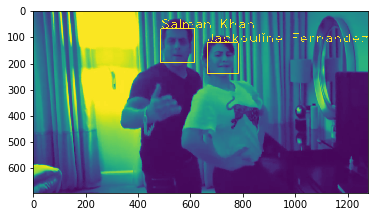

In [232]:
generate_box_and_name("/Users/abhinavrohilla/Desktop/Screen Shot 2018-09-25 at 3.20.14 PM.png",celebrities_in_pic)